# Series temporales en Keras

In [34]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Original data set retrieved from here:
# https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

data = pd.read_csv("datasets/international-airline-passengers.csv", 
                      usecols = [1], 
                      engine = "python", 
                      skipfooter = 3)

In [35]:
data.head()

,International airline passengers: monthly totals in thousands. Jan 49 -> Dec 60
0,112
1,118
2,132
3,129
4,121


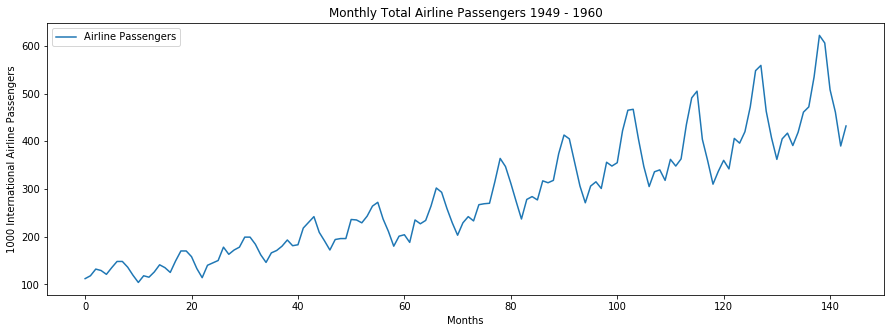

In [36]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

In [83]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle


## Preparación de los datos

In [124]:
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 0.5))
dataset = scaler.fit_transform(data_raw)


In [125]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (86, 58)


In [126]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [127]:
# Create test and training sets for one-step-ahead regression.
window_size = 3

train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
print("New training data shape:")
print(train_X.shape)


Original training data shape:
(82, 3)
New training data shape:
(82, 3, 1)


## Modelo

In [ ]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(20, 
                   input_shape = (window_size, 1)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    print(model.summary())
    
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)


# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

## Evaluación

In [182]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
        
    # plt.plot(orig_data[0])
    # plt.plot(pred[:, 0][0:])  # [1:]
    # plt.show()
    
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

print("-----------")

print(train_Y)
score = math.sqrt(mean_squared_error(scaler.inverse_transform([test_Y[:-1]]), scaler.inverse_transform([test_Y[1:]])))
print(score)


Training data score: 20.07 RMSE
Test data score: 44.56 RMSE
-----------
[0.02413128 0.01640926 0.02992278 0.04247104 0.04247104 0.03088804
 0.01447877 0.         0.01351351 0.01061776 0.02123552 0.03571428
 0.02992278 0.02027027 0.04343629 0.06370656 0.06370656 0.05212355
 0.02799228 0.00965251 0.03474903 0.03957529 0.04440154 0.07142857
 0.05694981 0.06563707 0.07142857 0.09169884 0.09169884 0.07722008
 0.05598456 0.04054055 0.05984555 0.06467181 0.07335907 0.08590734
 0.07432432 0.07625483 0.11003861 0.12162162 0.13320462 0.10135135
 0.08397684 0.06563707 0.08687259 0.08880308 0.08880308 0.12741312
 0.12644787 0.12065637 0.13416988 0.15444015 0.16216217 0.12837838
 0.10328186 0.07335907 0.09362935 0.09652509 0.08108108 0.12644787
 0.11872587 0.12548262 0.15444015 0.19111969 0.18243243 0.1496139
 0.12065637 0.09555985 0.12065637 0.13320462 0.12451737 0.15733589
 0.1592664  0.16023166 0.20366795 0.25096524 0.23455597 0.20077221
 0.16409267 0.12837838 0.16795366 0.17374517]
47.175712018

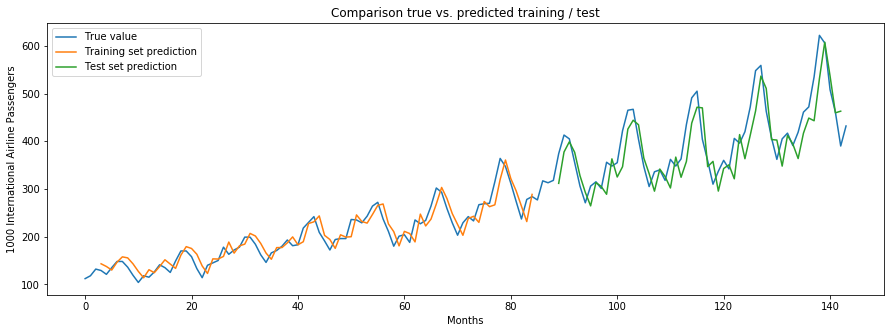

In [130]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()